In [2]:
import fitz  # PyMuPDF
import base64
from io import BytesIO
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from langchain.schema import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# -----------------------------
# CLIP Setup
# -----------------------------
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [21]:
from PIL import Image
import torch


def embedd_image(image_data):
    if isinstance(image_data,str): # if image path is given thi execute
        image = Image.open(image_data).convert("RGB")
    else:
        image = image_data
    inputs = clip_processor(images=image,return_tensors="pt")
    with torch.no_grad(): #normalizing image to unitvector
        features = clip_model.get_image_features(**inputs)
        features = features/features.norm(dim=1,keepdim=True)
        return features.squeeze().numpy()

def embedd_text(text):
    inputs = clip_processor(text=text,padding=True,return_tensors="pt",truncation=True,max_length=77)
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        features = features/features.norm(dim=1,keepdim=True)
        return features.squeeze().numpy()


In [ ]:
def extract_text_and_images(pdf_path):
    doc = fitz.open(pdf_path)
    data = []

    for i, page in enumerate(doc, start=1):
        # Text extraction
        text = page.get_text()
        if text.strip():
            data.append({
                "type": "text",
                "page": i,
                "content": text})

        # Image extraction
        image = page.get_images(full=True)
        for img_index, img in enumerate(image):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]

            img_base64 = base64.b64encode(image_bytes).decode("utf-8")

            data.append({
                "type": "image",
                "page": i,
                "content": img_base64
            })

    doc.close()
    return data


In [ ]:
# -----------------------------
# STEP 2 — Convert to LangChain Documents
# -----------------------------
def convert_to_documents(data):
    docs = []
    for item in data:
        if item["type"] == "text":
            docs.append(Document(
                page_content=item["content"],
                metadata={"type": "text",
                           "page": item["page"]}
            ))
        else:
            docs.append(Document(
                page_content="[IMAGE DATA]",
                metadata={"type": "image",
                           "page": item["page"],
                            "b64": item["content"]}
            ))
    return docs

In [30]:

# -----------------------------
# STEP 3 — Create multimodal embeddings
# -----------------------------
class MultiModalEmbeddings:
    def __init__(self):
        pass  # CLIP is already loaded globally

    def embed_documents(self, docs):
        embeddings = []
        for doc in docs:
            if doc.metadata["type"] == "text":
                emb = embedd_text(doc.page_content)
            elif doc.metadata["type"] == "image":
                img_data = base64.b64decode(doc.metadata["b64"])
                image = Image.open(BytesIO(img_data)).convert("RGB")
                emb = embedd_image(image)
            else:
                raise ValueError(f"Unknown doc type: {doc.metadata['type']}")
            embeddings.append(emb)
        return embeddings

    def embed_query(self, query):
        if isinstance(query, str):
            return embedd_text(query)
        elif isinstance(query, Image.Image):
            return embedd_image(query)
        else:
            raise ValueError("Unsupported query type for embedding")
        
    def __call__(self, text: str):
        return self.embed_query(text)



In [ ]:
# -----------------------------
# STEP 4 — Create Vector Store
# -----------------------------
def create_vectorstore(docs):
    embedder = MultiModalEmbeddings()
    embeddings = embedder.embed_documents(docs) #calling embed_document methood from MultieModalEmbidding class

    # All vectors now same dimension from CLIP
    text_embeddings = [(doc.page_content, emb) for doc, emb in zip(docs, embeddings)]

    vectorstore = FAISS.from_embeddings(
    text_embeddings=text_embeddings,
    embedding=embedder,  # So it can embed queries
    metadatas=[doc.metadata for doc in docs]
            )
    return vectorstore, embedder


In [32]:
# -----------------------------
# STEP 5 — RetrievalQA Pipeline
# -----------------------------
def build_rag_pipeline(vectorstore):
    retriever = vectorstore.as_retriever()
    llm = ChatOpenAI(model="gpt-4o", temperature=0)  # or "gpt-4o-mini" for cheaper
    qa = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=True
    )
    return qa

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


Answer: I'm unable to display images, but I can explain the content based on the text provided. The document summarizes revenue trends across the first three quarters of the year. It indicates that revenue grew steadily, with the highest growth recorded in Q3. In Q1, there was a moderate increase in revenue due to the introduction of new product lines. Q2 saw better performance than Q1, attributed to marketing campaigns. Q3 experienced exponential growth, primarily due to global expansion.

--- Retrieved Documents ---

[Page 1] TEXT:
Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart
below, revenue grew steadily with the highest growth recorded in Q3.
Q1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed
Q1 due to marketing campaigns. Q3 had exponential growth due to global expansion.


[Page 1] IMAGE:


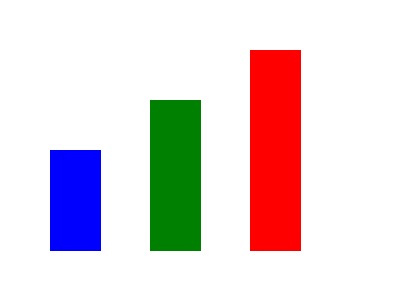

In [ ]:
from IPython.display import Image as IPImage, display


pdf_path = "multimodal_sample.pdf"
extracted_data = extract_text_and_images(pdf_path) #Extract text and Images from PDF
docs = convert_to_documents(extracted_data)  #convert to langchian Document
vs, embedder = create_vectorstore(docs) #Create vector store 
qa = build_rag_pipeline(vs)

query = "Sshow the image in document and explain it"
result = qa.invoke({"query": query})

print("Answer:", result["result"])
print("\n--- Retrieved Documents ---\n")

for doc in result["source_documents"]:
    if doc.metadata["type"] == "text":
        print(f"[Page {doc.metadata['page']}] TEXT:\n{doc.page_content}\n")
    elif doc.metadata["type"] == "image":
        print(f"[Page {doc.metadata['page']}] IMAGE:")
        img_data = base64.b64decode(doc.metadata["b64"])
        display(IPImage(data=img_data))